In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
param_grid = {'C': [10**k for k in range(-10, 6, 2)]}  
scoring = 'roc_auc'; cv = 3; random_state=42
random.seed(random_state)

In [3]:
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

# cosine similarity

In [4]:
cosine_sim = pd.DataFrame({'instrument': [],
                           'embedding': [],
                           'train set': [],
                          'cosine similarity': [],
                         })
project_method = '-lda'

for instrument in class_align:
    for embedding in ['vggish', 'openl3', 'yamnet']:
        for train_set in ['irmas', 'openmic']:

            embedding_sim = pd.DataFrame({'instrument': [],
                'embedding': [],
                'train set': [],
                'cosine similarity': [],
                })
            
            embedding_sim['instrument'] = [instrument]
            embedding_sim['embedding'] = [embedding]
            embedding_sim['train set'] = [train_set]

            file = open('models/LDAcoef_' + train_set + '_' + embedding + project_method + '.pickle', 'rb')
            dataset_sep = pickle.load(file)
            file.close()

            # load the trained instrument classification model
            file = open('models/models_' + train_set + '_' + embedding + '.pickle', 'rb')
            inst_sep = pickle.load(file)
            file.close()

            embedding_sim['cosine similarity'] = [cosine_similarity(inst_sep[instrument].best_estimator_.coef_, dataset_sep[instrument])[0][0]]
            
            cosine_sim = cosine_sim.append(embedding_sim)
    
cosine_sim.to_csv('results/cosine_similarity.csv', index=False)

In [5]:
cosine_sim

,instrument,embedding,train set,cosine similarity
0,cello,vggish,irmas,-8.988456e-02
0,cello,vggish,openmic,3.415998e-02
0,cello,openl3,irmas,-8.393736e-02
0,cello,openl3,openmic,5.880213e-02
0,cello,yamnet,irmas,-1.965158e-02
0,cello,yamnet,openmic,-1.252150e-04
0,clarinet,vggish,irmas,-2.845352e-01
0,clarinet,vggish,openmic,-1.919823e-02
0,clarinet,openl3,irmas,-1.074022e-01
0,clarinet,openl3,openmic,2.192099e-02


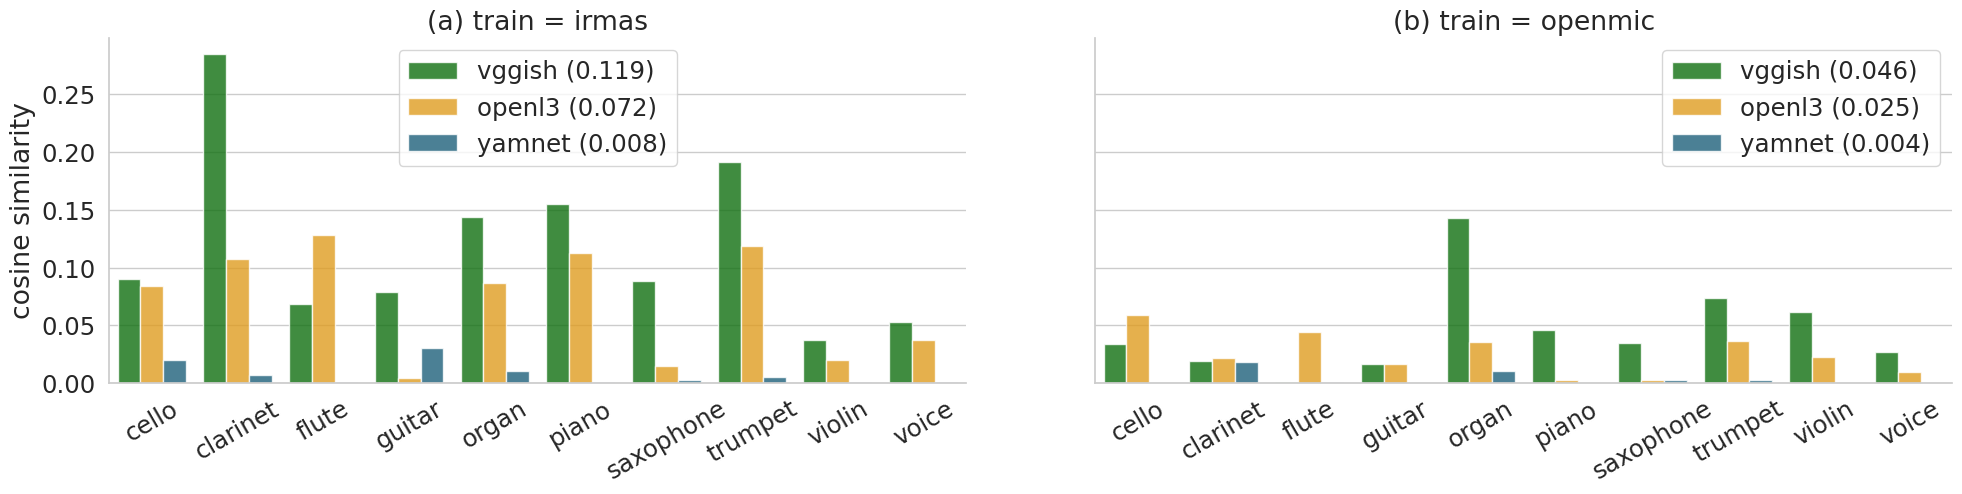

In [6]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = pd.read_csv('results/cosine_similarity.csv')
df['cosine similarity'] = abs(df['cosine similarity'])
ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
handles, labels = a0.get_legend_handles_labels()
df_irmas = df[df['train set']=='irmas']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_irmas[df_irmas['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text, ncol=1)
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
handles, labels = a1.get_legend_handles_labels()
df_openmic = df[df['train set']=='openmic']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_openmic[df_openmic['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text, ncol=1)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)
plt.savefig('results/cosine_similarity_ori_sameamount_aligninst.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')